## Imports & Loading the data

In [994]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [995]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [996]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

In [997]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [998]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [999]:
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = pickle.load(open('data_subsets_lags.pickle', 'rb'))

In [1000]:
sj_test.index.name = None
iq_test.index.name = None

In [1001]:
sj_train_train.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,...,cum_precip_5w_lag7,cum_precip_5w_lag8,cum_precip_6w_lag1,cum_precip_6w_lag2,cum_precip_6w_lag3,cum_precip_6w_lag4,cum_precip_6w_lag5,cum_precip_6w_lag6,cum_precip_6w_lag7,cum_precip_6w_lag8
2003-10-01,2003-10-01,sj,2003,40,-0.0335,0.01510,0.217486,0.208814,11.00,79.355714,...,125.1,126.0,224.8,165.3,171.2,199.2,177.4,150.8,143.0,139.0
2003-10-08,2003-10-08,sj,2003,41,0.0204,0.03275,0.163443,0.110371,6.30,76.435714,...,107.8,125.1,209.0,224.8,165.3,171.2,199.2,177.4,150.8,143.0
2003-10-15,2003-10-15,sj,2003,42,0.0161,0.03710,0.243400,0.267729,97.70,80.250000,...,169.4,107.8,140.2,209.0,224.8,165.3,171.2,199.2,177.4,150.8
2003-10-22,2003-10-22,sj,2003,43,-0.0416,0.05530,0.169929,0.128171,10.70,77.531429,...,150.3,169.4,171.4,140.2,209.0,224.8,165.3,171.2,199.2,177.4
2003-10-29,2003-10-29,sj,2003,44,0.0892,0.00035,0.094650,0.088114,17.08,77.561429,...,163.0,150.3,161.4,171.4,140.2,209.0,224.8,165.3,171.2,199.2


In [1002]:
# old
# sj_train_train, \
# sj_train_test, \
# iq_train_train, \
# iq_train_test = pickle.load(open('train_w_lags.pickle', 'rb'))

In [1003]:
def fill_from_train(df_test, df_train):
    null_cols = df_test.columns[df_test.isnull().any()]
    df_miss = df_test.loc[:,df_test[null_cols].columns]

    for i in range(df_miss.shape[1]):
        colname_miss = df_miss.iloc[:,i].name
        n_miss = df_miss.iloc[:,i].isnull().sum()
        data_for_gap = df_train.loc[:,colname_miss].iloc[-n_miss:]
        df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values

    return df_test

In [1004]:
sj_train_test = fill_from_train(sj_train_test, sj_train_train)
iq_train_test = fill_from_train(iq_train_test, iq_train_train)

/tmp/ipykernel_2695819/2268118587.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


# San Juan

## Extracting the seasonality 

<AxesSubplot:xlabel='weekofyear'>

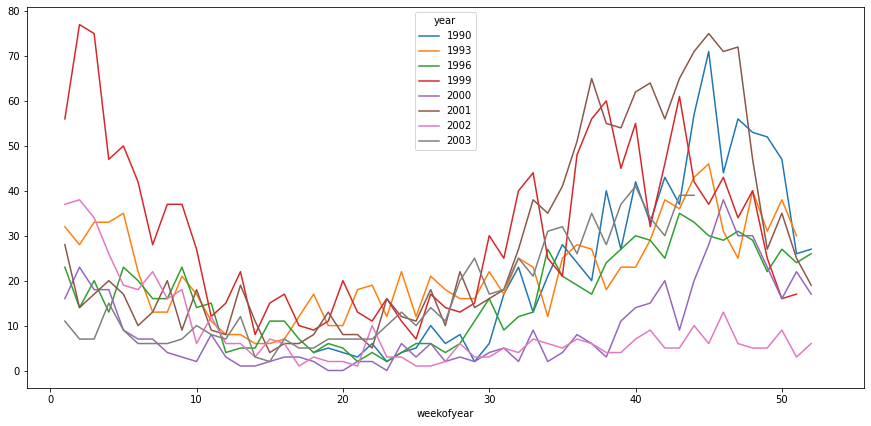

In [1005]:
(
    sj_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
#     .T
#     .lt(100)
#     .any()
    .loc[:,lambda df: df.max(axis=0) < 100]
    .plot()
)

In [1006]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames, cutoff=1000):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < cutoff]
            .mean(axis=1)
        )
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [1007]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases', cutoff=150)
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,38.537037
1,2,35.814815
2,3,34.629630
3,4,31.666667
4,5,26.888889


## Evaluating the saisonality as a baseline model

In [1008]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [1009]:
# seasonality_for_test(sj_train_test, sj_train_train_seas)

In [1010]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 27.5
--------------------
MAE: 18.12
Explained variance: 0.076
--------------------


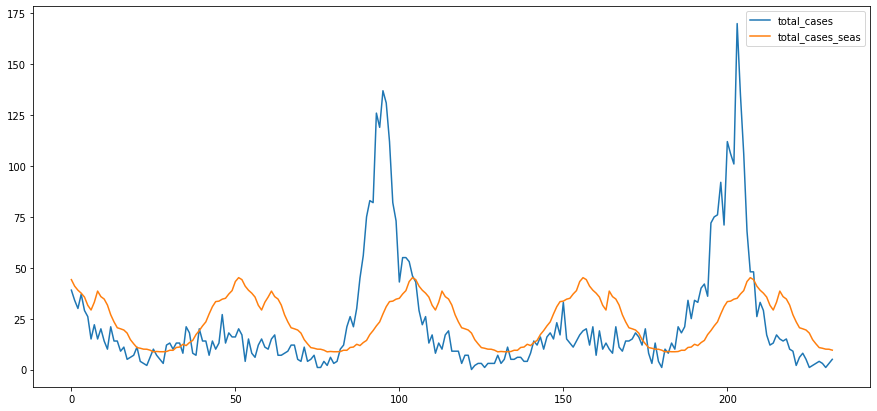

In [1011]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

## Substracting the saisonality

In [1012]:
def substract_seas(df, cols, seas_model, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas_model,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [1013]:
sj_train_train = substract_seas(sj_train_train, 'total_cases', sj_train_train_seas)
sj_train_test = substract_seas(sj_train_test, 'total_cases', sj_train_train_seas)

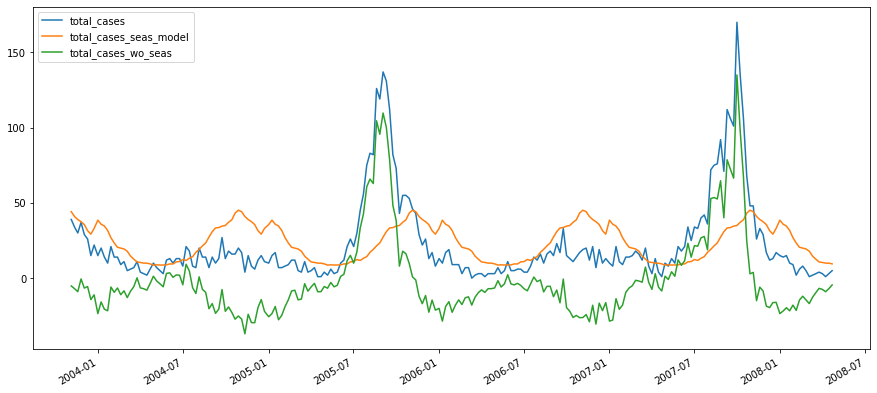

In [1014]:
(
    sj_train_test
    .loc[:,['total_cases', 'total_cases_seas_model', 'total_cases_wo_seas']]
    .plot()
);

# Regression (Random Forest)

## Preprocessing for Sklearn

In [1015]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_seas_model',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [1016]:
def custom_dropper(df, cols):
    '''
    drops rows with NaNs from a dataframe based on their presence in a subset of the df
    '''
    return df[df.index.isin(df[cols].dropna().index)]
# custom_dropper(sj_train_train, my_features)

## Feature selection

In [1017]:
# Using the Pearson correlation coefficients and a selection of the strongest
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases_wo_seas']
    .drop(['total_cases_wo_seas', 'total_cases_seas_model', 'total_cases'])
    .abs()
    .sort_values()
    .tail(7)
    .index
)

In [1018]:
# my_features

In [1019]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [1031]:
def reduce_features_lda_border(df, df_train, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(df_train[cols])
    df_scaled_train = pd.DataFrame(data=scaled_train, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled_train.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > border, 1, 0).tolist())
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [1032]:
def reduce_features_lda_bins(df, df_train, cols, target, n_comps=2, n_bins=2):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_train[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=n_comps)
    lda.fit(df_scaled.dropna(),
            pd.cut(custom_dropper(df_train, cols)[target], n_bins, labels=False))
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [1033]:
# X_train = sj_train_train[my_features].dropna()
# X_test = sj_train_test[my_features].dropna()

# X_train = reduce_features_pca(sj_train_train, my_features, n_pc=3)
# X_test = reduce_features_pca(sj_train_test, my_features, n_pc=3)

X_train = reduce_features_lda_border(sj_train_train, sj_train_train, my_features, target='total_cases_wo_seas', border=100)
X_test = reduce_features_lda_border(sj_train_test, sj_train_train, my_features, target='total_cases_wo_seas', border=100)

# X_train = reduce_features_lda_bins(sj_train_train, sj_train_train, my_features, target='total_cases_wo_seas', n_bins=10, n_comps=5)
# X_test = reduce_features_lda_bins(sj_train_test, sj_train_train, my_features, target='total_cases_wo_seas', n_bins=10, n_comps=5)

y_train = custom_dropper(sj_train_train, my_features).total_cases_wo_seas
y_test = custom_dropper(sj_train_test, my_features).total_cases_wo_seas


## Scaling

In [1023]:
from sklearn.preprocessing import StandardScaler

In [1024]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Regression (Linear Regression)

In [1025]:
from sklearn.linear_model import LinearRegression

In [1026]:
lm =LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [1027]:
y_train_pred = lm.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

In [1028]:
y_train = y_train + custom_dropper(sj_train_train, my_features).total_cases_seas_model
y_train_pred = y_train_pred + custom_dropper(sj_train_train, my_features).total_cases_seas_model

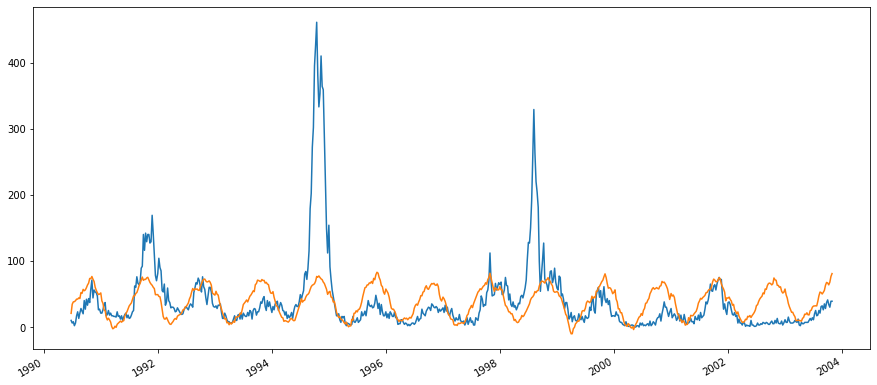

In [1029]:
y_train.plot()
y_train_pred.plot();

In [1030]:
model_classification(y_train, y_train_pred)

--------------------
RMSE: 51.7
--------------------
MAE: 27.55
Explained variance: 0.166
--------------------


In [971]:
y_test_pred = lm.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

In [972]:
y_test = y_test + custom_dropper(sj_train_test, my_features).total_cases_seas_model
y_test_pred = y_test_pred + custom_dropper(sj_train_test, my_features).total_cases_seas_model

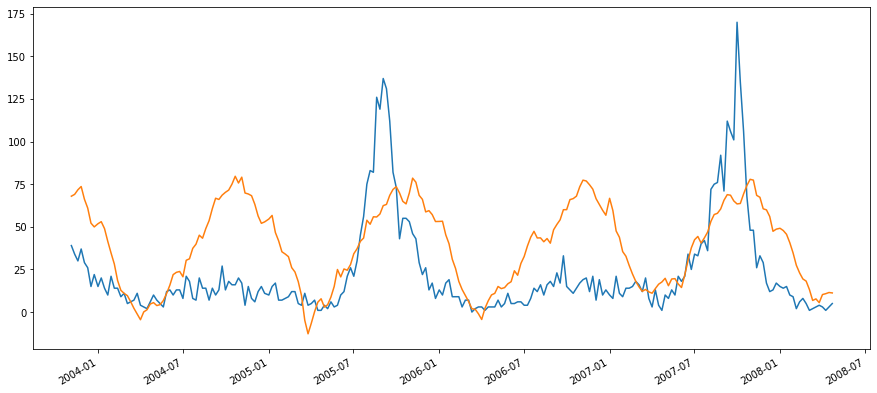

In [973]:
y_test.plot()
y_test_pred.plot();

In [974]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 31.41
--------------------
MAE: 24.57
Explained variance: 0.116
--------------------


## Regression (Random Forest)

In [1034]:
from sklearn.ensemble import RandomForestRegressor

In [1035]:
from sklearn.model_selection import GridSearchCV

In [1036]:
# Hyperparameter grid
param_grid = {
    'max_depth': [6, 7, 8],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [ 20, 22, 25, 27],
#     'bootstrap': [True, False],
    'min_samples_split': [2, 3, 5, 6],
    'n_estimators': [4, 5, 6]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
                  scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_split': 2, 'n_estimators': 4}
-29.239796908003324


In [1037]:
rf = gs.best_estimator_

In [1038]:
# rf = RandomForestRegressor(n_estimators=100,
#                            max_depth=10,
#                            min_samples_split= 5,
#                            max_leaf_nodes= 43,
# )

In [1039]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_leaf_nodes=20, n_estimators=4, n_jobs=-1)

In [1040]:
y_train_pred = rf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

In [1041]:
y_train = y_train + custom_dropper(sj_train_train, my_features).total_cases_seas_model
y_train_pred = y_train_pred + custom_dropper(sj_train_train, my_features).total_cases_seas_model

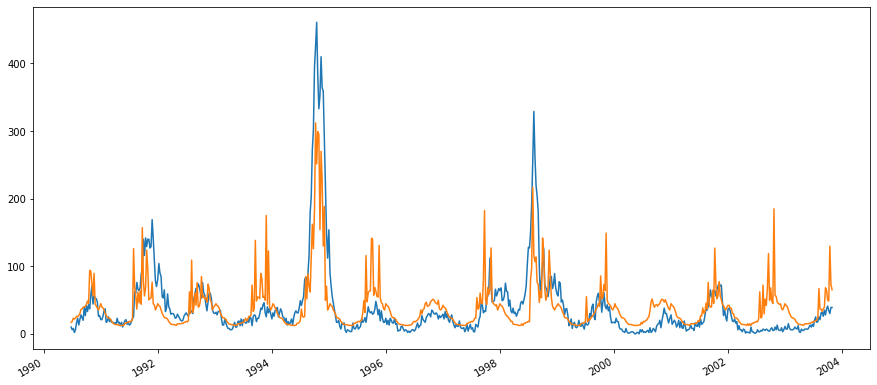

In [1042]:
y_train.plot()
y_train_pred.plot();

In [1043]:
model_classification(y_train, y_train_pred)

--------------------
RMSE: 38.45
--------------------
MAE: 22.43
Explained variance: 0.539
--------------------


In [1044]:
y_test_pred = rf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

In [1045]:
y_test = y_test + custom_dropper(sj_train_test, my_features).total_cases_seas_model
y_test_pred = y_test_pred + custom_dropper(sj_train_test, my_features).total_cases_seas_model

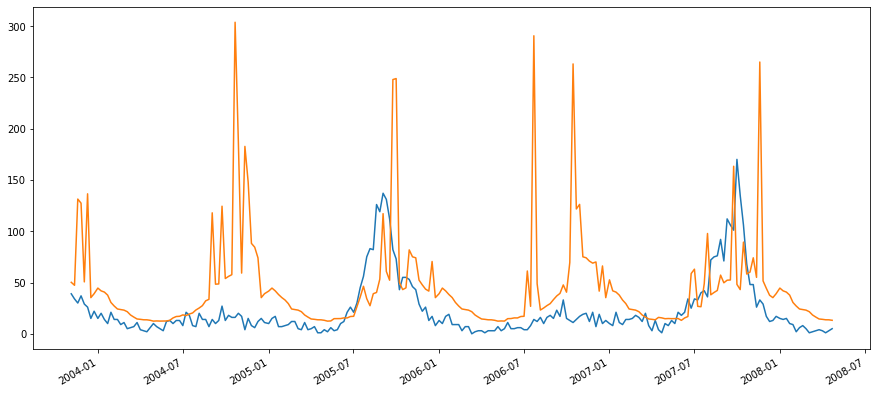

In [1046]:
y_test.plot()
y_test_pred.plot();

In [1047]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 53.47
--------------------
MAE: 31.5
Explained variance: -1.891
--------------------


## Smoothing

In [1048]:
def lossless_centered_smoothing(test_pred, train_y, w=3):
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[:int((w-1) / 2)] = trunk
        smoothed[-int((w-1) / 2):] = tail

    return smoothed

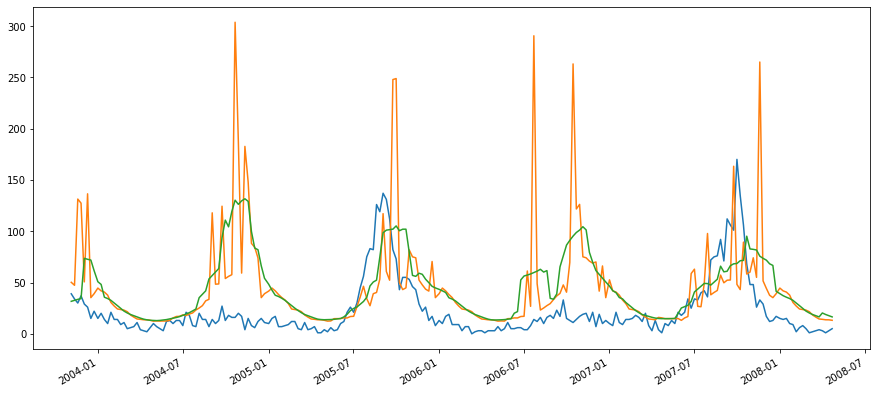

In [1049]:
y_test.plot()
y_test_pred.plot();
lossless_centered_smoothing(y_test_pred, y_train, w=9).plot();

In [1050]:
model_classification(y_test, lossless_centered_smoothing(y_test_pred, y_train, w=9))

--------------------
RMSE: 38.09
--------------------
MAE: 28.47
Explained variance: -0.208
--------------------


## For the real test data

In [842]:
sj_train = pd.concat([sj_train_train, sj_train_test], axis=0)
iq_train = pd.concat([iq_train_train, iq_train_test], axis=0)

In [777]:
sj_train_seas = get_smooth_seasonality_df(sj_train, 'total_cases', cutoff=150)
sj_train_seas.head()

,weekofyear,total_cases
0,1,30.564103
1,2,29.358974
2,3,28.051282
3,4,25.461538
4,5,21.615385


## Substracting the saisonality

In [290]:
def substract_seas_simplified(df, seas_model):
    df_mod = (
        df
        .assign(total_cases_wo_seas = df['total_cases'] - df['total_cases_seas_model'])
    )
    return df_mod

In [291]:
sj_train = substract_seas_simplified(sj_train, sj_train_seas)

# Regression (Random Forest)

## Preprocessing for Sklearn

## Feature selection

In [295]:
# Using the Pearson correlation coefficients and a selection of the strongest
corr_mat = sj_train.corr()
my_features = (
    corr_mat['total_cases_wo_seas']
    .drop(['total_cases_wo_seas', 'total_cases_seas_model', 'total_cases'])
    .abs()
    .sort_values()
#     .tail(100)
    .index
)

In [296]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [318]:
def reduce_features_lda_border(df, df_train, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_train[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > border, 1, 0).tolist())
    lda_comps = lda.transform(df[cols].dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[my_features].dropna().index
    return lda_df

In [319]:
# X_train = sj_train_train[my_features].dropna()
# X_test = sj_train_test[my_features].dropna()

# X_train = reduce_features_pca(sj_train_train, my_features, n_pc=3)
# X_test = reduce_features_pca(sj_train_test, my_features, n_pc=3)

X_train = reduce_features_lda_border(sj_train, sj_train, my_features, target='total_cases_wo_seas', border=80)
X_test = reduce_features_lda_border(sj_test, sj_train, my_features, target='total_cases_wo_seas', border=80)

# X_train = reduce_features_lda_bins(sj_train_train, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)
# X_test = reduce_features_lda_bins(sj_train_test, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)

y_train = custom_dropper(sj_train, my_features).total_cases_wo_seas
y_test = custom_dropper(sj_test, my_features).total_cases_wo_seas


AttributeError: 'DataFrame' object has no attribute 'total_cases_wo_seas'

## Scaling

In [147]:
from sklearn.preprocessing import StandardScaler

In [148]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Regression (Random Forest)

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [150]:
from sklearn.model_selection import GridSearchCV

In [151]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [3, 5, 10, 20],
    'max_depth': [1, 2, 3],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [10, 15, 20, 30, 50],
#     'bootstrap': [True, False],
    'min_samples_split': [5, 7, 10]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
                  scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

# gs.fit(X_train, y_train)
# print(gs.best_params_)
# print(gs.best_score_)

In [152]:
# rf = gs.best_estimator_

In [153]:
rf = RandomForestRegressor(n_estimators=100,
#                            max_depth=20,
#                            min_samples_split= 5,
                           max_leaf_nodes= 43,
)

In [154]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_leaf_nodes=43)

In [155]:
y_train_pred = rf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

In [156]:
y_train = y_train + custom_dropper(sj_train_train, my_features).total_cases_seas_model
y_train_pred = y_train_pred + custom_dropper(sj_train_train, my_features).total_cases_seas_model

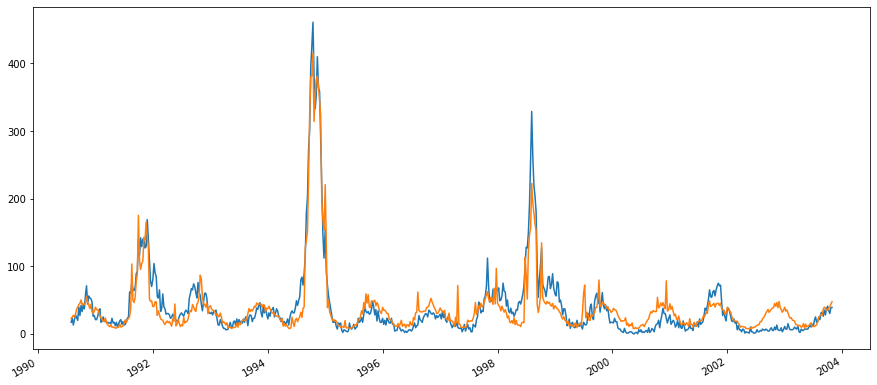

In [157]:
y_train.plot()
y_train_pred.plot();

In [158]:
model_classification(y_train, y_train_pred)

--------------------
RMSE: 19.52
--------------------
MAE: 14.13
Explained variance: 0.882
--------------------


In [159]:
y_test_pred = rf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

In [160]:
y_test = y_test + custom_dropper(sj_train_test, my_features).total_cases_seas_model
y_test_pred = y_test_pred + custom_dropper(sj_train_test, my_features).total_cases_seas_model

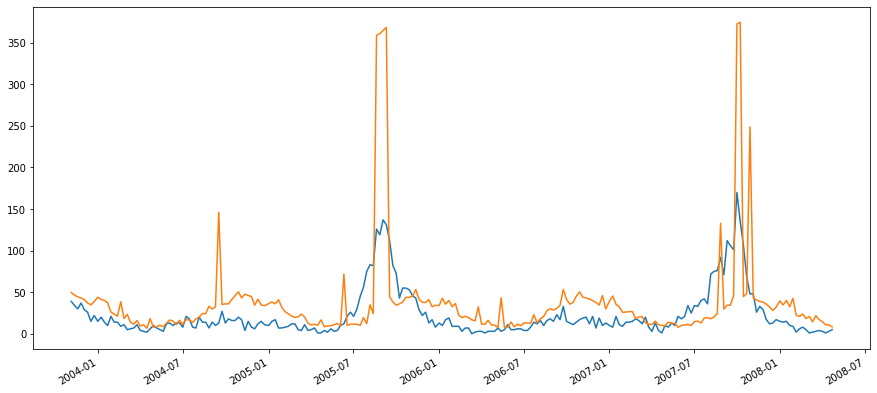

In [161]:
y_test.plot()
y_test_pred.plot();

In [162]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 45.99
--------------------
MAE: 24.36
Explained variance: -1.338
--------------------


## Smoothing

In [163]:
def lossless_centered_smoothing(test_pred, train_y, w=3):
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[:int((w-1) / 2)] = trunk
        smoothed[-int((w-1) / 2):] = tail

    return smoothed

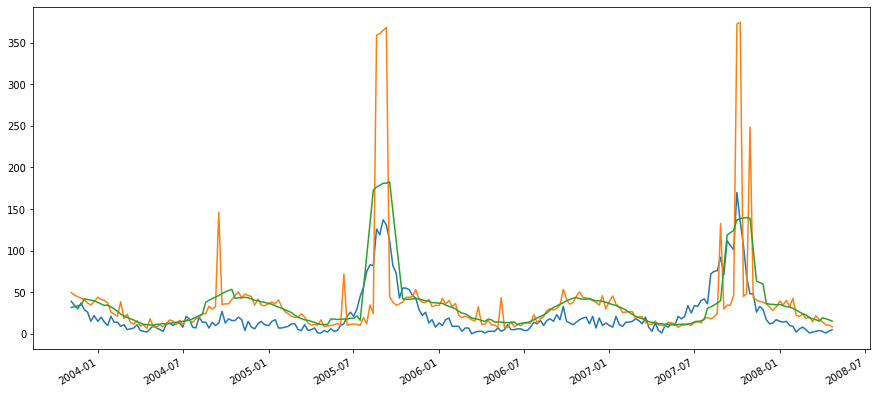

In [164]:
y_test.plot()
y_test_pred.plot();
lossless_centered_smoothing(y_test_pred, y_train, w=9).plot();

In [165]:
model_classification(y_test, lossless_centered_smoothing(y_test_pred, y_train, w=9))

--------------------
RMSE: 23.32
--------------------
MAE: 18.28
Explained variance: 0.581
--------------------


In [54]:
# save this for excercising the submission
# sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=3)

# Iquitos

## Extracting the seasonality 

<AxesSubplot:xlabel='weekofyear'>

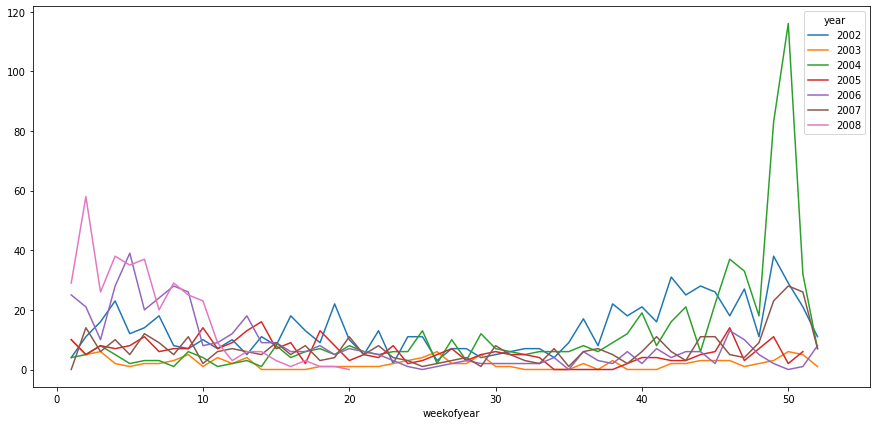

In [843]:
(
    iq_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
#     .loc[:,lambda df: df.max(axis=0) < 100]
    .plot()
)

In [844]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames, cutoff=1000):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < cutoff]
            .mean(axis=1)
        )
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [845]:
iq_train_train_seas = get_smooth_seasonality_df(iq_train_train, 'total_cases', cutoff=60)
iq_train_train_seas.head()

,weekofyear,total_cases
0,1,13.666667
1,2,14.666667
2,3,16.333333
3,4,15.555556
4,5,16.888889


## Evaluating the saisonality as a baseline model

In [846]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [847]:
# seasonality_for_test(iq_train_test, iq_train_train_seas)

In [848]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 10.43
--------------------
MAE: 6.01
Explained variance: 0.156
--------------------


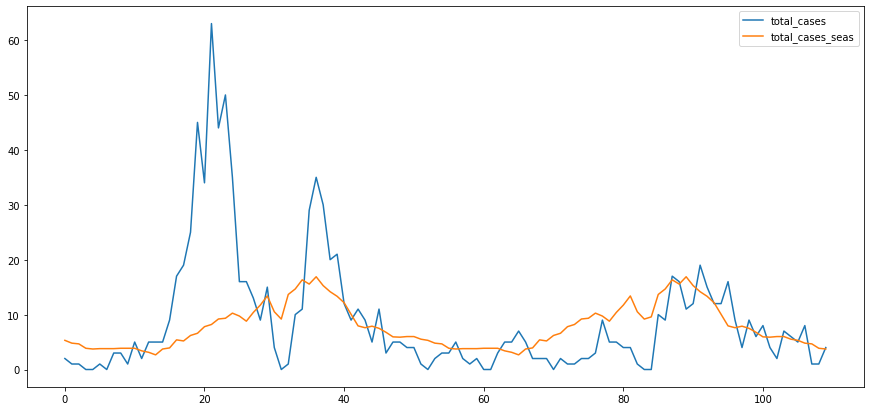

In [849]:
seasonality_baseline_eval(iq_train_test, iq_train_train_seas)

## Substracting the saisonality

In [850]:
def substract_seas(df, cols, seas_model, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas_model,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [851]:
iq_train_train = substract_seas(iq_train_train, 'total_cases', iq_train_train_seas)
iq_train_test = substract_seas(iq_train_test, 'total_cases', iq_train_train_seas)

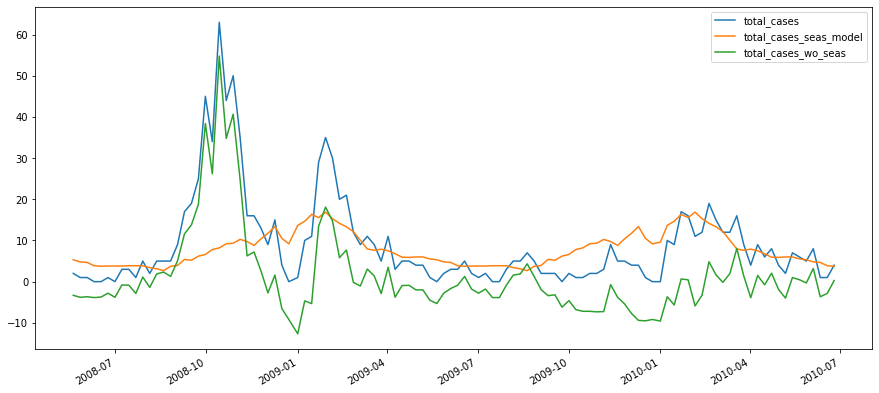

In [852]:
(
    iq_train_test
    .loc[:,['total_cases', 'total_cases_seas_model', 'total_cases_wo_seas']]
    .plot()
);

# Regression (Random Forest)

## Preprocessing for Sklearn

## Feature selection

In [887]:
# Using the Pearson correlation coefficients and a selection of the strongest
corr_mat = iq_train_train.corr()
my_features = (
    corr_mat['total_cases_wo_seas']
    .drop(['total_cases_wo_seas', 'total_cases_seas_model', 'total_cases'])
    .abs()
    .sort_values()
    .tail(100)
    .index
)

In [888]:
# my_features

In [889]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [890]:
# X_train = iq_train_train[my_features].dropna()
# X_test = iq_train_test[my_features].dropna()

# X_train = reduce_features_pca(iq_train_train, my_features, n_pc=3)
# X_test = reduce_features_pca(iq_train_test, my_features, n_pc=3)

X_train = reduce_features_lda_border(iq_train_train, iq_train_train, my_features, target='total_cases_wo_seas', border=40)
X_test = reduce_features_lda_border(iq_train_test,iq_train_train, my_features, target='total_cases_wo_seas', border=40)

# X_train = reduce_features_lda_bins(iq_train_train, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)
# X_test = reduce_features_lda_bins(iq_train_test, my_features, target='total_cases_wo_seas', n_bins=2, n_comps=1)

y_train = custom_dropper(iq_train_train, my_features).total_cases_wo_seas
y_test = custom_dropper(iq_train_test, my_features).total_cases_wo_seas


## Scaling

In [891]:
from sklearn.preprocessing import StandardScaler

In [892]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

## Regression (Random Forest)

In [893]:
from sklearn.ensemble import RandomForestRegressor

In [894]:
from sklearn.model_selection import GridSearchCV

In [895]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [3, 5, 10, 20],
    'max_depth': [1, 2, 3],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [10, 15, 20, 30, 50],
#     'bootstrap': [True, False],
    'min_samples_split': [5, 7, 10]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
                  scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

# gs.fit(X_train, y_train)
# print(gs.best_params_)
# print(gs.best_score_)

In [896]:
# rf = gs.best_estimator_

In [897]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=20,
                           min_samples_split= 5,
                           max_leaf_nodes= 43,
)

In [898]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_leaf_nodes=43, min_samples_split=5)

In [899]:
y_train_pred = rf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

In [900]:
y_train = y_train + custom_dropper(iq_train_train, my_features).total_cases_seas_model
y_train_pred = y_train_pred + custom_dropper(iq_train_train, my_features).total_cases_seas_model

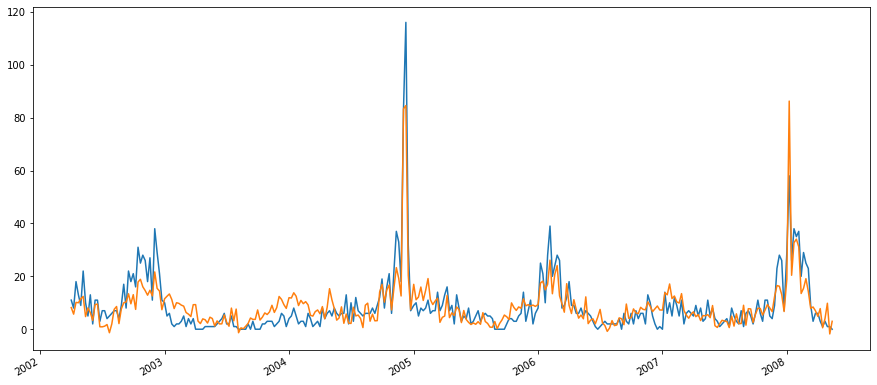

In [901]:
y_train.plot()
y_train_pred.plot();

In [902]:
model_classification(y_train, y_train_pred)

--------------------
RMSE: 5.63
--------------------
MAE: 4.21
Explained variance: 0.752
--------------------


In [903]:
y_test_pred = rf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

In [904]:
y_test = y_test + custom_dropper(iq_train_test, my_features).total_cases_seas_model
y_test_pred = y_test_pred + custom_dropper(iq_train_test, my_features).total_cases_seas_model

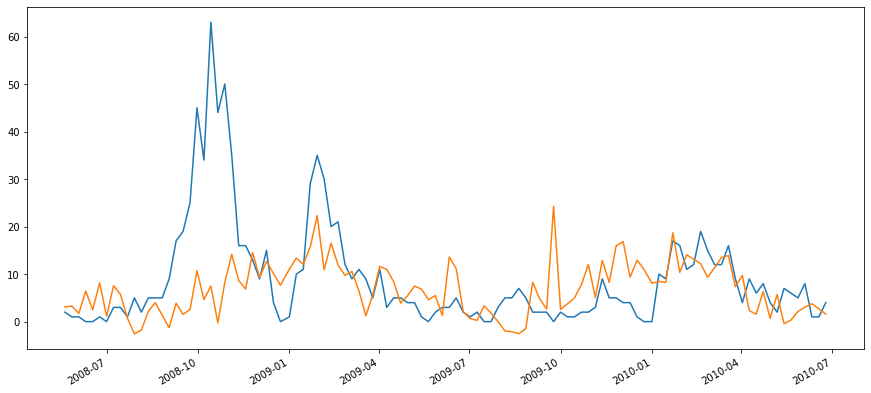

In [905]:
y_test.plot()
y_test_pred.plot();

In [906]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 11.38
--------------------
MAE: 6.94
Explained variance: 0.019
--------------------


## Smoothing

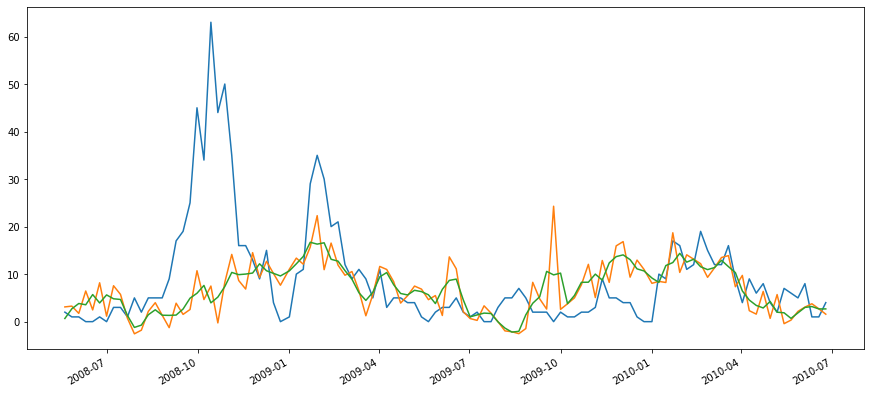

In [907]:
y_test.plot()
y_test_pred.plot();
lossless_centered_smoothing(y_test_pred, y_train, w=3).plot();

In [908]:
model_classification(y_test, lossless_centered_smoothing(y_test_pred, y_train, w=3))

--------------------
RMSE: 11.16
--------------------
MAE: 6.68
Explained variance: 0.059
--------------------


In [909]:
# save this for excercising the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=3)

## Building a submission table

In [88]:
# load the submission file
submission = pd.read_csv('data/submission_format.csv')
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0
...,...,...,...,...
411,iq,2013,22,0
412,iq,2013,23,0
413,iq,2013,24,0
414,iq,2013,25,0


In [89]:
def subm_builder_ind_city(pred, test_df):
    pred = pred.reset_index().rename(columns={
        'index': 'week_start_date',
        0: 'total_cases'
    })
    subm_indcity = pd.merge(test_df[['city', 'year', 'weekofyear','week_start_date']], pred).drop('week_start_date', axis=1)
    return subm_indcity

def subm_builder(pred_1, test_df_1, pred_2, test_df_2):
    subm_city_1 = subm_builder_ind_city(pred_1, test_df_1)
    subm_city_2 = subm_builder_ind_city(pred_2, test_df_2)
    subm_table = pd.concat([subm_city_1, subm_city_2], axis=0)
    return subm_table

In [90]:
# Just an excercise! with train_test data
subm_builder(sj_pred_subm, sj_train_test, iq_pred_subm, iq_train_test)

,city,year,weekofyear,total_cases
0,sj,2003,45,36.000000
1,sj,2003,46,48.517497
2,sj,2003,47,46.300213
3,sj,2003,48,44.510090
4,sj,2003,49,42.040954
...,...,...,...,...
105,iq,2010,21,8.966815
106,iq,2010,22,4.655130
107,iq,2010,23,3.761222
108,iq,2010,24,4.971148
